In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns

from data_io import get_data
from data_representation import one_hot_encoding
from utils import plot_class_distribution, pred_results

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.feature_selection import (
    SelectKBest, VarianceThreshold, f_classif)

from sklearn.metrics import (
    f1_score, balanced_accuracy_score, roc_auc_score,
    average_precision_score, precision_recall_curve)

import xgboost as xgb

# Human

## Data

Read in the human data sets where the input sequences are split by all 2-mers

In [3]:
form = 'split'
species = 'human'

In [4]:
k = 2

In [ ]:
X_train_raw, y_train = get_data(species, form=form, mode='train', k=k, drop=0.0)

In [ ]:
X_val_raw, y_val = get_data(species, form=form, mode='val', k=k)

In [ ]:
X_test_raw, y_test = get_data(species, form=form, mode='test', k=k)

In [ ]:
X_hidden_raw, _ = get_data(species, form=form, mode='hidden', k=k)

In [9]:
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Representation

 Encode each 2-mer with 1-hot encoding

In [10]:
X_train = one_hot_encoding(X_train_raw, k=k)
X_val = one_hot_encoding(X_val_raw, k=k)
X_test = one_hot_encoding(X_test_raw, k=k)
X_hidden = one_hot_encoding(X_hidden_raw, k=k)

In [11]:
X_train.shape

(500000, 5955)

In [12]:
X_hidden.shape

(30021, 5955)

### Feature Selection

We select the best 1024 non-constant features based on the f_classif score

In [13]:
var_thresh = VarianceThreshold(threshold=1e-9)

var_thresh.fit(X_train, y_train)

X_train = X_train[:, var_thresh.get_support()]
X_val = X_val[:, var_thresh.get_support()]
X_test = X_test[:, var_thresh.get_support()]
X_hidden = X_hidden[:, var_thresh.get_support()]

In [14]:
k_best = SelectKBest(f_classif, k=1024)

k_best.fit(X_train, y_train)

X_train = X_train[:, k_best.get_support()]
X_val = X_val[:, k_best.get_support()]
X_test = X_test[:, k_best.get_support()]
X_hidden = X_hidden[:, k_best.get_support()]

## Classifier

#### Data

In [15]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, y_test)
dhidden = xgb.DMatrix(X_hidden)

#### Training

Optimal parameters found by grid-search

In [16]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 12,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'colsample_bylevel': 1.0,
    'colsample_bynode': 1.0,
    'eta': 0.3,
    'lambda': 32,
    'eval_metric': ['auc', 'aucpr'],
    'gamma': 0.1,
    'scale_pos_weight': 5
    }

In [17]:
evallist = [(dtrain, 'train'), (dval, 'eval')]

Train a maximum of 1024 trees, looking at the evaulation AUPRC to determine early stopping

In [18]:
num_round = 1024
bst = xgb.train(
    params=params,  
    dtrain=dtrain, 
    num_boost_round=num_round, 
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=False)

##### Prediction

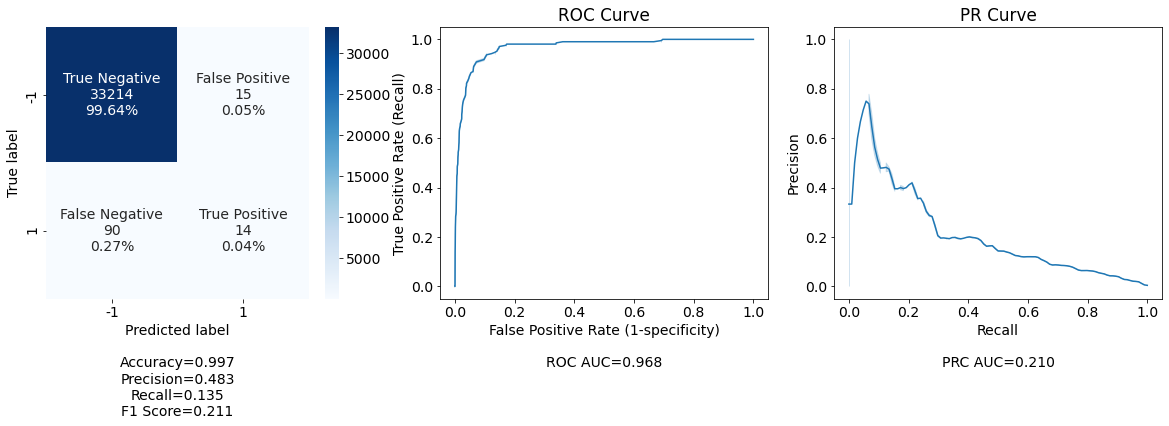

In [28]:
y_probs_test, y_pred_test, results_test = pred_results(
    bst, dtest, y_test,
    model_type='xgb', 
    model_name='xgboost',
    figsize=(20,5))

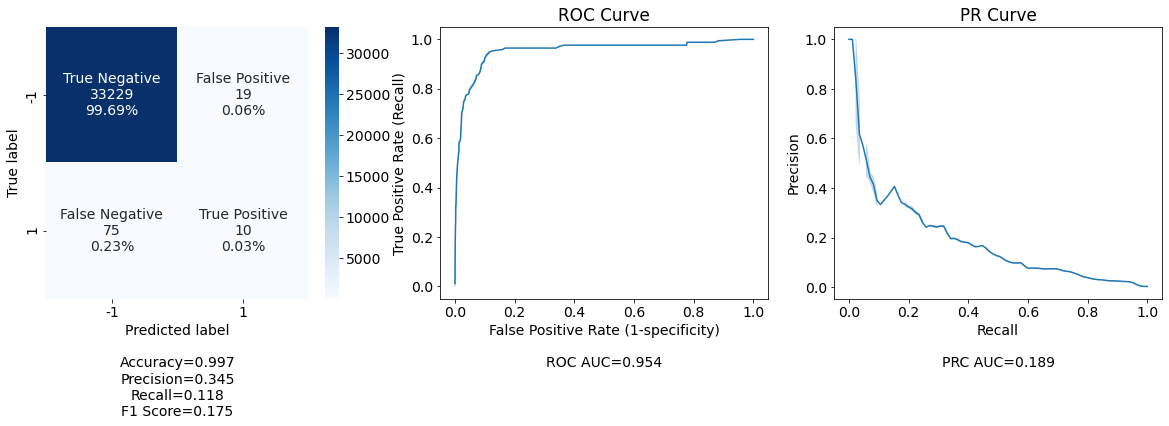

In [29]:
y_probs_val, y_pred_val, results_val = pred_results(
    bst, dval, y_val,
    model_type='xgb', 
    model_name='xgboost',
    figsize=(20,5))

#### Evaluation

In [30]:
print(roc_auc_score(y_test, y_probs_test, average='macro'))
print(average_precision_score(y_test, y_probs_test, average='macro'))

0.9682801399148565
0.21581461894040452


In [31]:
print(roc_auc_score(y_val, y_probs_val, average='macro'))
print(average_precision_score(y_val, y_probs_val, average='macro'))

0.9538484402423144
0.19322629721698245


#### Hidden data

In [22]:
y_probs_hidden = bst.predict(dhidden)

#### Store results

In [23]:
pd.DataFrame(y_probs_hidden).to_csv("./predictions/proba_human_hidden_xgboost_submit.csv")

In [32]:
pd.DataFrame(y_probs_test).to_csv("./predictions/proba_human_test_xgboost_submit.csv")

In [33]:
pd.DataFrame(y_probs_val).to_csv("./predictions/proba_human_val_xgboost_submit.csv")

### Save model

In [24]:
bst.save_model('submit-xgb-human.model')

# Worm

Here, the same is repeted on the worm data set, with the only difference being that we encode 1-mers instead of 2-mers and that we select fewer features (80).

## Data

In [34]:
form = 'split'
species = 'worm'

In [35]:
k = 1

In [ ]:
X_train_raw, y_train = get_data(species, form=form, mode='train', k=k, drop=0.0)

In [ ]:
X_val_raw, y_val = get_data(species, form=form, mode='val', k=k)

In [ ]:
X_test_raw, y_test = get_data(species, form=form, mode='test', k=k)

In [39]:
y_train[y_train < 0] = 0
y_val[y_val < 0] = 0
y_test[y_test < 0] = 0

### Representation

In [40]:
X_train = one_hot_encoding(X_train_raw, k=k)
X_val = one_hot_encoding(X_val_raw, k=k)
X_test = one_hot_encoding(X_test_raw, k=k)

In [41]:
X_train.shape

(1540, 246)

### Feature Selection

In [42]:
var_thresh = VarianceThreshold(threshold=1e-9)

var_thresh.fit(X_train, y_train)

X_train = X_train[:, var_thresh.get_support()]
X_val = X_val[:, var_thresh.get_support()]
X_test = X_test[:, var_thresh.get_support()]

In [43]:
k_best = SelectKBest(f_classif, k=80)

k_best.fit(X_train, y_train)

X_train = X_train[:, k_best.get_support()]
X_val = X_val[:, k_best.get_support()]
X_test = X_test[:, k_best.get_support()]

## Classifier

#### Data

In [44]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test, y_test)

#### Training

In [45]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 14,
    'subsample': 0.8,
    'colsample_bytree': 0.5,
    'colsample_bylevel': 1.0,
    'colsample_bynode': 1.0,
    'eta': 0.3,
    'lambda': 32,
    'eval_metric': ['auc', 'aucpr'],
    'gamma': 0.1,
    'scale_pos_weight': 10
    }

In [46]:
evallist = [(dtrain, 'train'), (dval, 'eval')]

In [47]:
num_round = 1024
bst = xgb.train(
    params=params,  
    dtrain=dtrain, 
    num_boost_round=num_round, 
    evals=evallist,
    early_stopping_rounds=20,
    verbose_eval=False)


##### Prediction

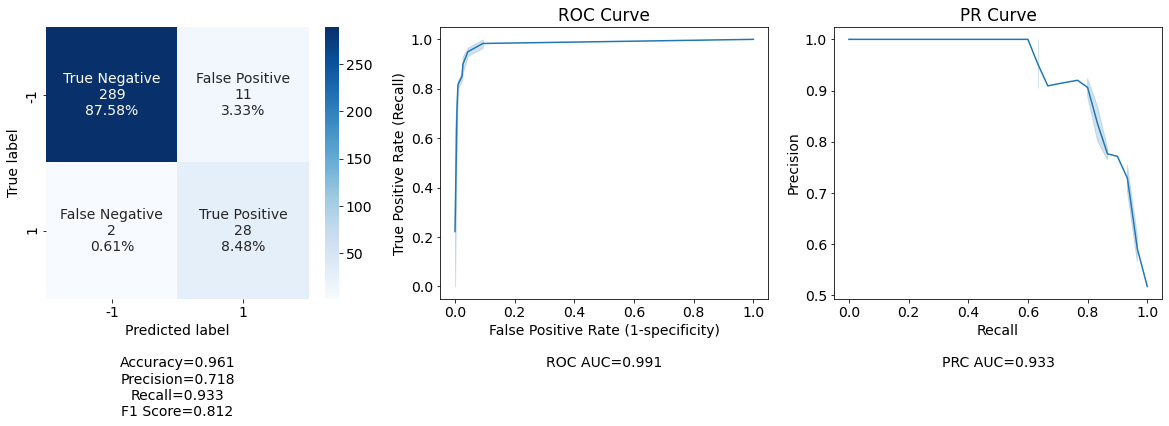

In [53]:
y_probs_test, y_pred_test, results = pred_results(
    bst, dtest, y_test,
    model_type='xgb', 
    model_name='xgboost',
    figsize=(20,5))

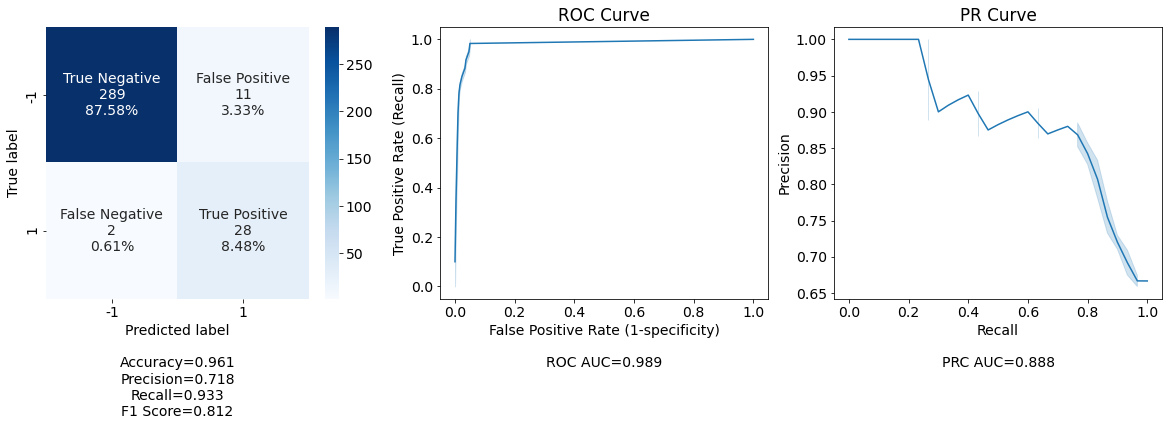

In [54]:
y_probs_val, y_pred_val, results_val = pred_results(
    bst, dval, y_val,
    model_type='xgb', 
    model_name='xgboost',
    figsize=(20,5))

#### Evaluation

In [56]:
print(roc_auc_score(y_test, y_probs_test, average='macro'))
print(average_precision_score(y_test, y_probs_test, average='macro'))

0.9914444444444444
0.9339845942274728


In [57]:
print(roc_auc_score(y_val, y_probs_val, average='macro'))
print(average_precision_score(y_val, y_probs_val, average='macro'))

0.9894444444444443
0.88998152678988


In [58]:
pd.DataFrame(y_probs_test).to_csv("./predictions/proba_worm_test_xgboost_submit.csv")

In [59]:
pd.DataFrame(y_probs_val).to_csv("./predictions/proba_worm_val_xgboost_submit.csv")

### Save model

In [43]:
bst.save_model('submit-xgb-worm.model')